# 3. Logistic Regression
Predicting the outcome of a shot given its features

`Logistic regression` is used when the targeted outcome is classified into two outcomes. But as linear regression only predict 0 or 1, we can with logistic regression we get a probability between 0 and 1 which is useful for the probability of a goal.

### Prepare data and all things for predictions

In [1]:
#import libearies
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
#the url´s where the data is stored
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

In [3]:
#create our parse data function
def parse_data(competition_id, season_id):
    matches = requests.get(url = comp_url.format(competition_id, season_id)).json()
    match_ids = [match["match_id"] for match in matches]
    
    all_events = []
    for match_id in match_ids:
        
        events = requests.get(url = match_url.format(match_id)).json()
        
        shots = [x for x in events if x["type"]["name"] == "Shot"]
        for shot in shots:
            attributes = {
                "x": shot["location"][0],
                "y": shot["location"][1],
                "minute": shot["minute"],
                "head": 1 if shot["shot"]["body_part"]["name"] == "Head" else 0,
                "phase": shot["shot"]["type"]["name"],
                "outcome": 1 if shot["shot"]["outcome"]["name"] == "Goal" else 0,
                "statsbomb_xg": shot["shot"]["statsbomb_xg"]
            }
            all_events.append(attributes)
        
    return pd.DataFrame(all_events)

This time we have added additional data to the `parse_data` function to give our model different features to work with and therefore create the best model.
- x - the x-coordinate of the shot ranges from 0 to 120
- y - the y-coordinate of the shot ranges from 0 to 80
- minute - what minute the shot were taken
- head - if the shot was attempted with the head
- phase - what phase of play did the shot come from
- outcome - did the shot result in a goal
- statsbomb_xg - for comparison purposes at the end of the notebook

**Note:** _We will not use the xG as a feature to our model because the xG is already a really prediction of the outcome of if the shot resulted in a goal._

**Why these features**:
- x and y
- minute
- head
- phase
- outcome
- statsbomb_xg

In [4]:
#load data from 2018 World Cup
competition_id = 43
season_id = 3
df = parse_data(43, 3)

In [5]:
df.head()

,x,y,minute,outcome,head,phase,statsbomb_xg
0,115.0,34.0,0,1,0,Open Play,0.094462
1,112.0,36.0,3,1,0,Open Play,0.236519
2,101.0,55.0,11,0,0,Free Kick,0.053822
3,103.0,24.0,18,0,0,Open Play,0.029023
4,96.0,37.0,22,0,0,Open Play,0.041431


#### We can now create some measurements about the shots, which we believe are a good predictor if the shot results in a goal. 
More precise are these features of the shot `distance_to_goal` and `goal_angle`.

In [6]:
#function that calculates the distance to the center of the goal
def distance_to_goal(origin):
    dest = np.array([120., 40.])
    return np.sqrt(np.sum((origin - dest) ** 2))

In [7]:
#function that calculates the angle within the shot is taken
def goal_angle(origin):
    p0 = np.array((120., 36.))  # Left Post
    p1 = np.array(origin, dtype=np.float)
    p2 = np.array((120., 44.))  # Right Post

    v0 = p0 - p1
    v1 = p2 - p1

    angle = np.abs(np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1)))
    
    return angle

We will now add these columns to our dataframe.

We will use the technique `broadcasting`, which is efficient in large datasets. (https://stackoverflow.com/questions/29954263/what-does-the-term-broadcasting-mean-in-pandas-documentation)

We are also using the `lambda` to avoid loopig through our pandas df.

In [8]:
df['distance_to_goal'] = df.apply(lambda row: distance_to_goal(row[['x', 'y']]), axis=1)
df['goal_angle'] = df.apply(lambda r: goal_angle(r[['x', 'y']]), axis=1)

We now removes Free Kicks and Penalties from our dataframe/training set.

This done because having Free Kicks and Penalties will skew our results, because most samples comes from Open Play.

In [9]:
shots = df[~df['phase'].isin(['Free Kick', 'Penalty'])]

## Prediction and logistic regression

In [11]:
#choose the features and what we want to predict
features = ['distance_to_goal', 'goal_angle', 'head']
target = 'outcome'

The `features` of the model will be distance, angle and if the shot were headed. These features ww think are good features to predict if the shot will result in a goal.

The `target` is what we want to predict. We want to predict if the shot results in a goal (1) or no goal (0).

In [13]:
shots[features+[target]].head()

,distance_to_goal,goal_angle,head,outcome
0,7.810250,0.726642,0,1
1,8.944272,0.785398,0,1
3,23.345235,0.251639,0,0
4,24.186773,0.325437,0,0
5,13.453624,0.411456,0,0


In [14]:
#create train- and test set
test_data = (shots.loc[:, features+[target]]
             .sample(frac=.2))

train_data = (shots.loc[~shots.index.isin(test_data.index.values), 
                        features+[target]]) 

print(f"train: {train_data.shape}\ntest: {test_data.shape}") #print the dimension of our data, to see if done correctly

train: (1245, 4)
test: (311, 4)


In `test_data` we selects a sample of 20% of the shots with the features and target dimensions

In `train_data` we selects the remaining instances from the shots
This is done excluding the index values from the shots data, which appears in the `test_data`

In [15]:
#import the logistic model initialize our model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

#train our model on the train_data
fit = model.fit(train_data.loc[:, features], 
                train_data.loc[:, target])

Firstly we import `LogisticRegression` to we can initialize a model.

We can then train our model on the `train_data`.

In [16]:
#we can now make our prediction with the model we have just trained
predictions = pd.DataFrame(model.predict_proba(test_data.loc[:, features]), 
                           index = test_data.index, 
                           columns=[0, f"{target}_prob"])

In [17]:
predictions.head()

,0,outcome_prob
627,0.941764,0.058236
838,0.861035,0.138965
979,0.957649,0.042351
141,0.832379,0.167621
1330,0.971564,0.028436


Above we make our model makes the predtictions on our `test_data`.

- `model.predict_proba` function because we want to predict a probability of the shot resulting in a goal (i.e. xg).
- `ìndex` we match the index to the indices from the `test_data`. This is done because otherwise our `predictions` wouldn't match the `test_data` and the predictions would look very wrong.
- `columns` we rename the second column to _outcome_ \_prob, because this column represents our model predicted goal probability of the shot.

In [18]:
#add predicted column to our `test_data`
test_data[f"{target}_pred"] = predictions[f"{target}_prob"]

Our models prediction is then added to the `test_data` so we can make a quick investigation of the precision of our models predictions.

In [19]:
test_data.sample(10)

,distance_to_goal,goal_angle,head,outcome,outcome_pred
1146,12.806248,0.408149,1,0,0.048673
700,15.000000,0.331765,0,0,0.082432
1358,4.123106,1.446441,1,0,0.280420
204,11.313708,0.519146,0,0,0.137880
821,25.000000,0.305407,0,0,0.031314
16,22.803509,0.278300,0,0,0.037528
645,11.704700,0.628796,0,0,0.148248
102,26.000000,0.283096,0,0,0.027753
1385,10.295630,0.674741,1,0,0.081397
778,6.708204,1.027319,1,0,0.158337


We will validate if the models predictions are any good with an accuracy test.

In [25]:
from sklearn.metrics import accuracy_score

#calculate accuracy, first argument is the real outcome and the second argument is the predicted outcome
##we round the probabilites to get either 0 or 1, dependent if the probability is greater or lower than 0.5
accuracy_score(test_data[target], test_data[f"{target}_pred"].round(0))

0.9003215434083601

So accuracy is basically how accurate our model is in predticting if the shot were a goal. I.e. how many times did your model predict __goal (1)__ when the shot was a __goal (1)__ and __no goal (0)__, when the shot was a __no goal (0)__.

As we can see the `accuracy is 90%`, which is realitively good. But when we take into consideration that a lot of the shots results in no goal (0). The accuracy isn't so good, because the model could just predict no goal for all shots and the accuracy would still be around 90%. Which we can see below.

In [26]:
accuracy_score(test_data[target], np.zeros(test_data[target].shape))

0.9067524115755627

So you could easily argue that we should use different features, which are better predictors for if the shot would result in a goal.

Therefore is a better metric to evaluate our model is to look at the `Log Loss` function and compare it to if the model would only predict `no goal`. The `Log Loss` function is a measure of _"How likely did the model think the actually observed set of outcomes was"_. (https://www.kaggle.com/dansbecker/what-is-log-loss)

This means that we can compare probabilities instead of binary 0's or 1's.

In [47]:
from sklearn.metrics import log_loss
print("prediction log loss:", f"""{log_loss(test_data[target], test_data[f"{target}_pred"])}""")
print("prediction log loss:", f"""{log_loss(test_data[target], np.repeat(test_data[target].mean(), test_data[target].shape))}""")

prediction log loss: 0.2685514199236648
prediction log loss: 0.3099878540629775


A more intiutive evaluation of our model is just to compare our model to the `statsbomb_xg` probabilities (xg) (i.e. compare our minimalistic model to their were robust xg model).

By plotting 311 random samples of statsbombs xg probabilities we can compare to our model and see that the distribution looks quite similar.

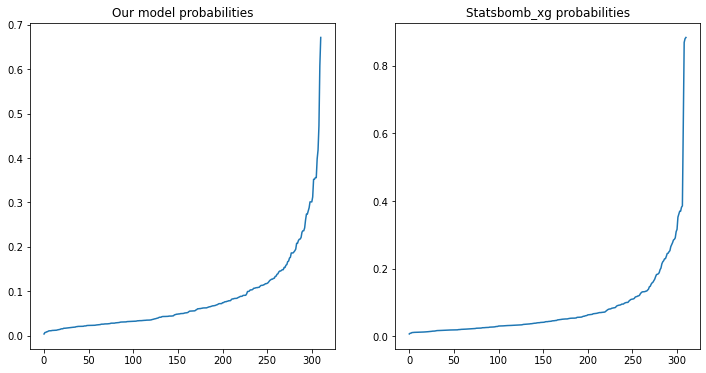

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(sorted(predictions[f"{target}_prob"]))
ax2.plot(sorted(shots['statsbomb_xg'].sample(311)))

ax1.set_title("Our model probabilities")
ax2.set_title("Statsbomb_xg probabilities")
plt.show()

-------------------------
--------------------------

This is a very simple logistic regression model, but in the notebook `xG_model` I will attempt to improve this model and expand to others model and see how they perform.